In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.effects
import soundfile as sf
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from IPython.display import Audio

In [2]:
DATA_DIR = Path("./data/RAVDESS")
file_pattern = re.compile(r"^(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})\.wav$", re.I)

emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
intensity_map = {"01": "normal", "02": "strong"}
vocal_map = {"01": "speech", "02": "song"}


In [3]:
rows = []
for actor in sorted(DATA_DIR.glob("Actor_*")):
    for f in actor.glob("*.wav"):
        m = file_pattern.match(f.name)
        if m:
            modality, vocal, emotion, intensity, stmt, rep, actor_id = m.groups()
            actor_num = int(actor_id)
            gender = "male" if actor_num % 2 == 1 else "female"
            rows.append({
                "path": f,
                "actor": actor_id,
                "gender": gender,
                "emotion": emotion_map.get(emotion, emotion),
                "intensity": intensity_map.get(intensity, intensity),
                "vocal": vocal_map.get(vocal, vocal)
            })
        else:
            print("Filename not matching pattern:", f)

df = pd.DataFrame(rows)
print(f"Total files found: {len(df)}")
df.head()

Total files found: 1440


,path,actor,gender,emotion,intensity,vocal
0,data/RAVDESS/Actor_01/03-01-04-02-01-01-01.wav,01,male,sad,strong,speech
1,data/RAVDESS/Actor_01/03-01-07-02-02-01-01.wav,01,male,disgust,strong,speech
2,data/RAVDESS/Actor_01/03-01-07-02-01-02-01.wav,01,male,disgust,strong,speech
3,data/RAVDESS/Actor_01/03-01-05-02-01-01-01.wav,01,male,angry,strong,speech
4,data/RAVDESS/Actor_01/03-01-02-01-01-02-01.wav,01,male,calm,normal,speech


---------------
emotion
sad          192
disgust      192
angry        192
calm         192
happy        192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64
---------------
intensity
normal    768
strong    672
Name: count, dtype: int64
---------------
vocal
speech    1440
Name: count, dtype: int64
---------------
gender
male      720
female    720
Name: count, dtype: int64


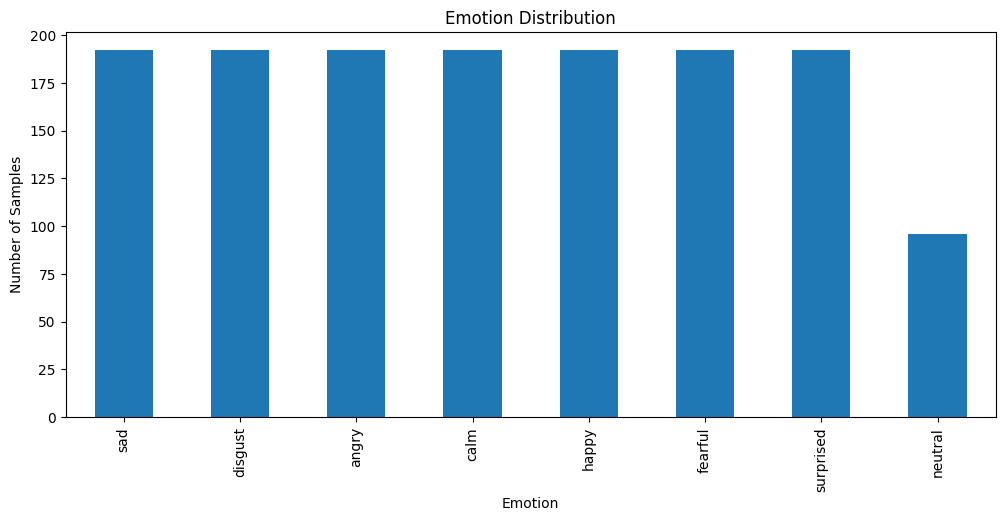

In [4]:
print("-"*15)
print(df['emotion'].value_counts())
print("-"*15)
print(df['intensity'].value_counts())
print("-"*15)
print(df['vocal'].value_counts())
print("-"*15)
print(df['gender'].value_counts())

plt.figure(figsize=(12, 5))
df['emotion'].value_counts().plot(kind='bar', title='Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.show()


In [5]:
durations = []
sampling_rates = []
rms_values = []

# audio_signal = the raw waveform as a NumPy array
# sampling_rate = number of samples per second (Hz)

for audio_file in tqdm(df['path'], desc="Analyzing audio"):
    signal, sr = librosa.load(audio_file, sr=None)

    durations.append(len(signal)/sr)
    sampling_rates.append(sr)
    
    rms = np.sqrt(np.mean(signal**2)) # root mean squares (loudness / signal energy)
    rms_values.append(rms)

df['duration'] = durations
df['sr'] = sampling_rates
df['rms'] = rms_values

df.describe()[['duration', 'rms']]


Analyzing audio: 100%|██████████| 1440/1440 [00:05<00:00, 263.48it/s]


,duration,rms
count,1440.000000,1440.000000
mean,3.700665,0.018024
std,0.336676,0.022418
min,2.936271,0.000652
25%,3.470146,0.005040
50%,3.670333,0.009919
75%,3.870542,0.020265
max,5.271937,0.152168


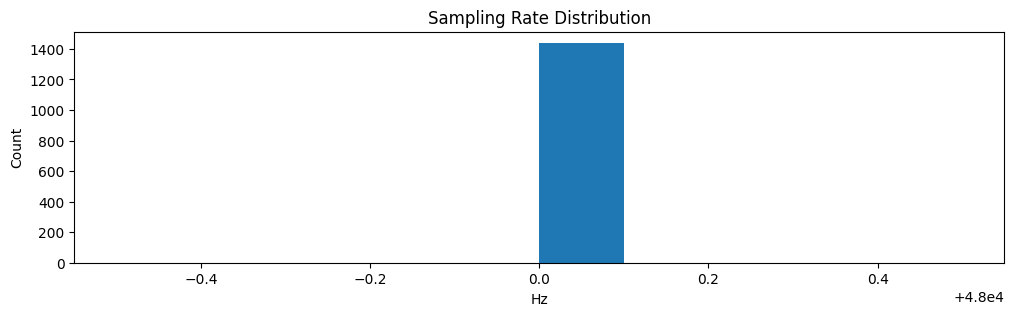

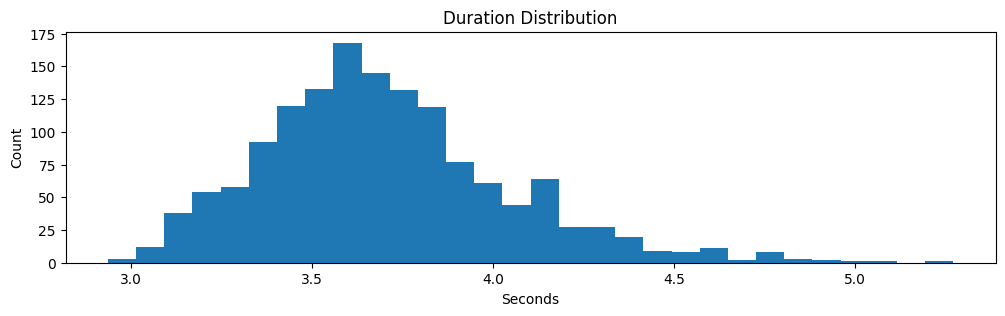

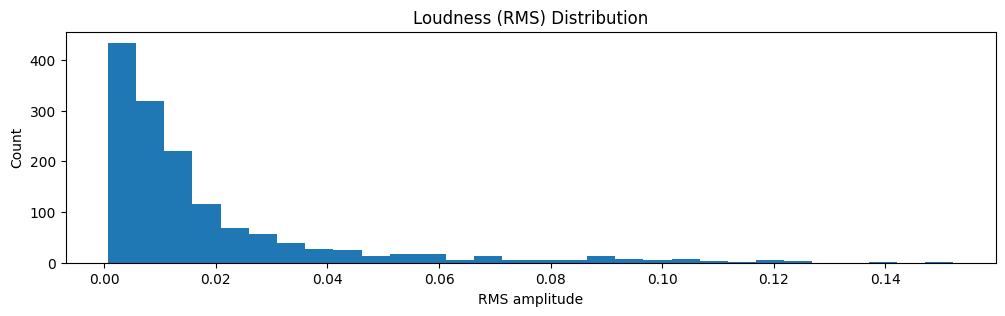

In [6]:
plt.figure(figsize=(12,3))
plt.hist(df['sr'], bins=10)
plt.title("Sampling Rate Distribution")
plt.xlabel("Hz")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(df['duration'], bins=30)
plt.title("Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,3))
plt.hist(df['rms'], bins=30)
plt.title("Loudness (RMS) Distribution")
plt.xlabel("RMS amplitude")
plt.ylabel("Count")
plt.show()


In [7]:
def explore_audio(path):
    y, sr = librosa.load(path, sr=None)
    dur = len(y)/sr
    print(f"File: {path}")
    print(f"SR: {sr} | Duration: {dur:.2f}s | Peak: {np.max(np.abs(y)):.3f} | RMS: {np.sqrt(np.mean(y**2)):.3f}")

    display(Audio(y, rate=sr))

    fig, ax = plt.subplots(3, 1, figsize=(14, 10))

    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set_title("Waveform")

    # STFT Spectrogram
    S = np.abs(librosa.stft(y))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=ax[1])
    ax[1].set_title("STFT Spectrogram")
    plt.colorbar(img1, ax=ax[1])

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    img2 = librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax[2])
    ax[2].set_title("Mel Spectrogram")
    plt.colorbar(img2, ax=ax[2])

    plt.tight_layout()
    plt.show()


# try it on an example file
# explore_audio(df['path'].iloc[10])


Unique sampling rates: [48000]


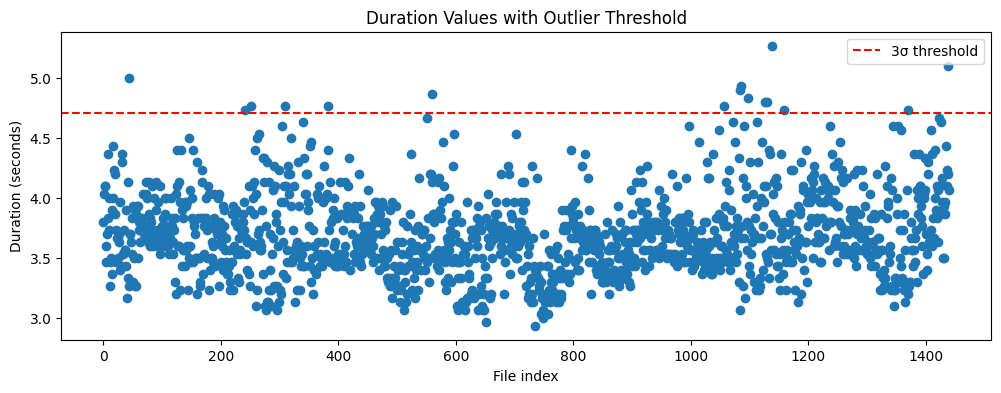

In [8]:
print("Unique sampling rates:", df['sr'].unique())

# Check outliers in duration
# df[df['duration'] > df['duration'].mean() + 3*df['duration'].std()]

plt.figure(figsize=(12, 4))
plt.scatter(range(len(df)), df['duration'])
plt.axhline(df['duration'].mean() + 3*df['duration'].std(), color='r', linestyle='--', label='3σ threshold')
plt.xlabel('File index')
plt.ylabel('Duration (seconds)')
plt.title('Duration Values with Outlier Threshold')
plt.legend()
plt.show()




In [9]:
pitch_means = []
centroid_means = []

for audio_file in tqdm(df['path'], desc="Computing pitch/centroid"):
    signal, sr = librosa.load(audio_file, sr=None)
    pitch, _ = librosa.piptrack(y=signal, sr=sr)
    pitch_means.append(np.mean(pitch[pitch>0]) if np.any(pitch>0) else 0)
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    centroid_means.append(np.mean(centroid))

df['pitch_mean'] = pitch_means
df['centroid_mean'] = centroid_means

df[['pitch_mean', 'centroid_mean']].describe()


Computing pitch/centroid: 100%|██████████| 1440/1440 [00:50<00:00, 28.31it/s]


,pitch_mean,centroid_mean
count,1440.000000,1440.000000
mean,1700.701538,5560.179301
std,218.860214,810.351458
min,894.840393,2604.357648
25%,1562.216919,4970.886721
50%,1761.056335,5575.320637
75%,1867.725586,6140.463131
max,2072.602539,7655.335725


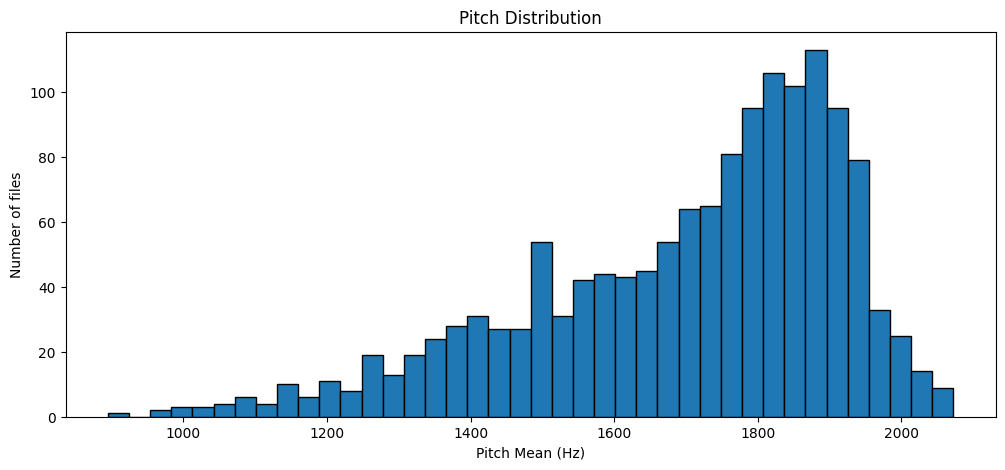

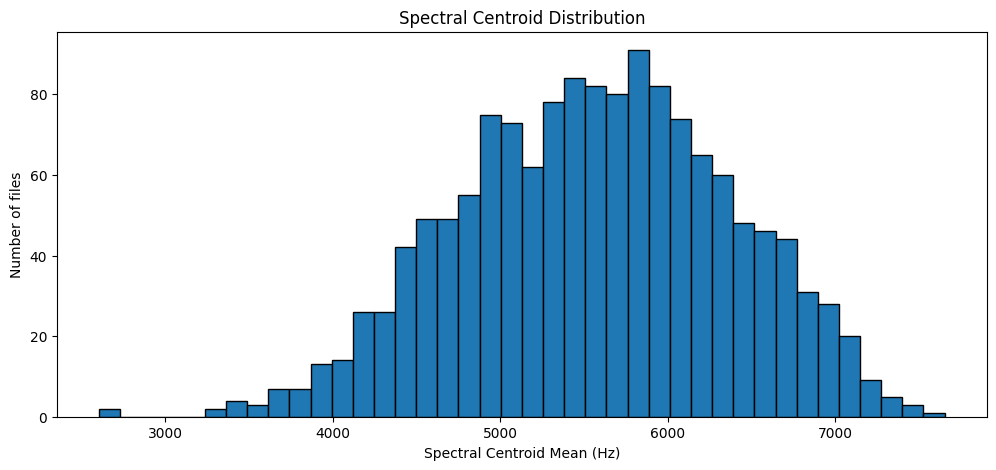

In [10]:
plt.figure(figsize=(12, 5))
plt.hist(df['pitch_mean'], bins=40, edgecolor='black')
plt.xlabel('Pitch Mean (Hz)')
plt.ylabel('Number of files')
plt.title('Pitch Distribution')
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(df['centroid_mean'], bins=40, edgecolor='black')
plt.xlabel('Spectral Centroid Mean (Hz)')
plt.ylabel('Number of files')
plt.title('Spectral Centroid Distribution')
plt.show()


In [11]:
# Average duration and RMS per emotion
class_summary = df.groupby("emotion")[["duration", "rms", "pitch_mean", "centroid_mean"]].mean()
print(class_summary)


           duration       rms   pitch_mean  centroid_mean
emotion                                                  
angry      3.871404  0.045863  1747.136230    5446.037533
calm       3.795806  0.004314  1639.308472    5604.167397
disgust    3.941785  0.010752  1688.242188    5553.440437
fearful    3.574231  0.027687  1776.257324    5353.518100
happy      3.638183  0.021001  1714.008179    5422.459939
neutral    3.503153  0.005373  1618.870483    5847.746437
sad        3.694490  0.008629  1693.617798    5617.314606
surprised  3.487512  0.014247  1687.256714    5780.533526


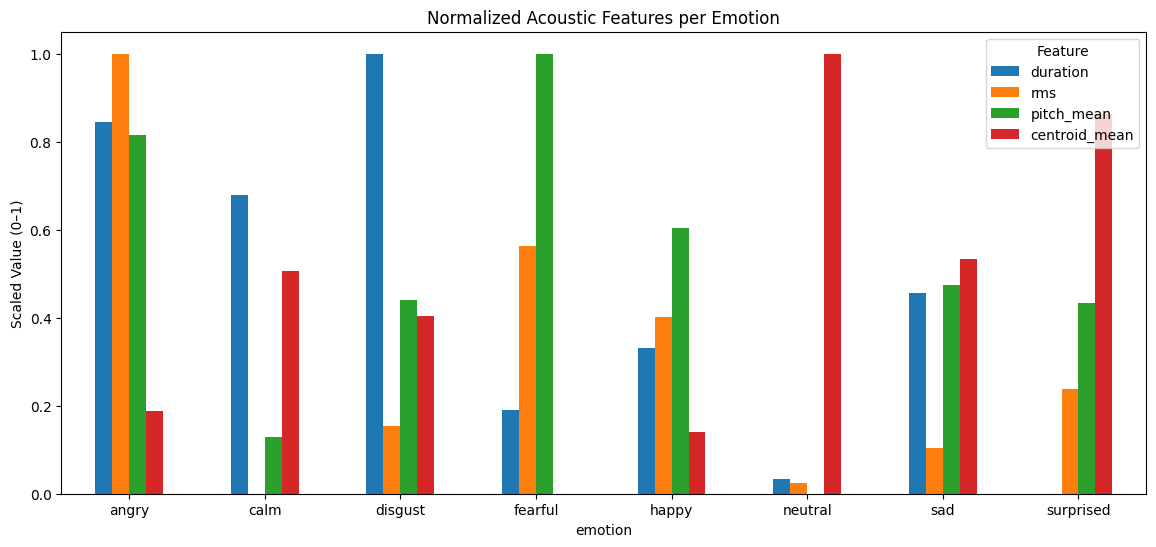

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(class_summary)
scaled_df = pd.DataFrame(scaled, index=class_summary.index, columns=class_summary.columns)

scaled_df.plot(kind='bar', figsize=(14,6))
plt.title('Normalized Acoustic Features per Emotion')
plt.ylabel('Scaled Value (0–1)')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()



In [13]:
silence_ratios = []
for audio_file in tqdm(df['path'], desc="Silence check"):
    signal, sr = librosa.load(audio_file, sr=None)
    non_silent, _ = librosa.effects.trim(signal, top_db=30)
    silence_ratio = 1 - (len(non_silent) / len(signal))
    silence_ratios.append(silence_ratio)

df["silence_ratio"] = silence_ratios


Silence check: 100%|██████████| 1440/1440 [00:06<00:00, 228.87it/s]


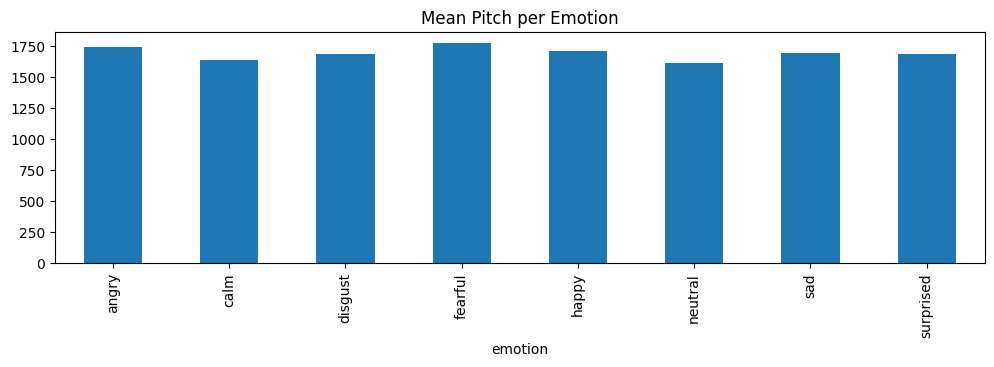

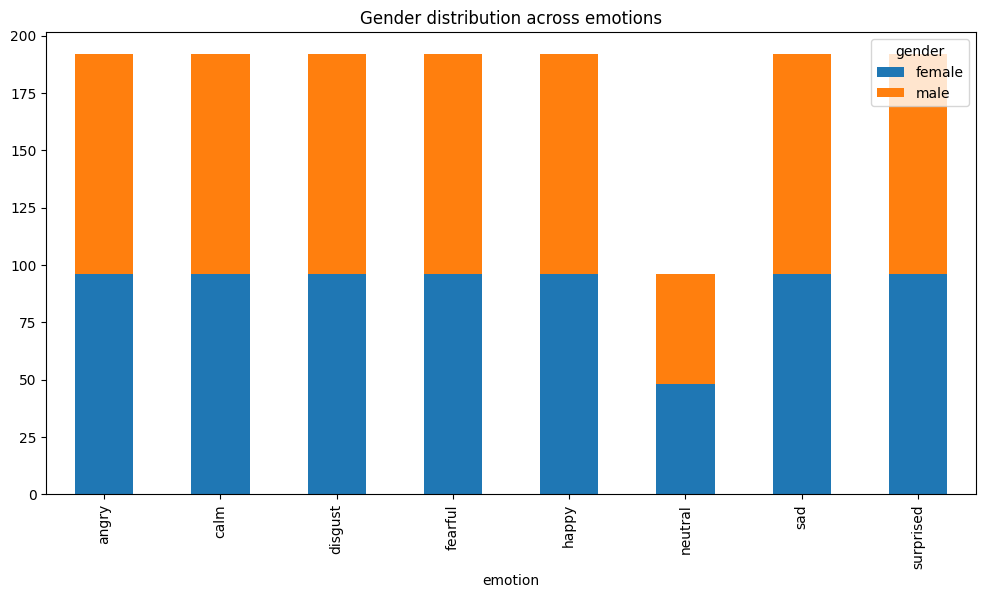

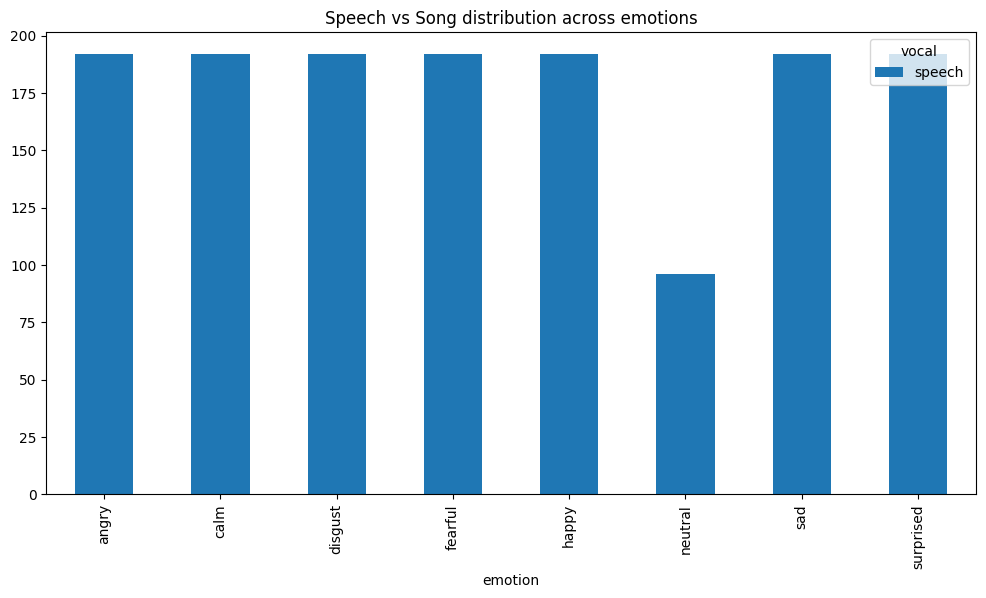

In [14]:
plt.figure(figsize=(12, 3))
df.groupby('emotion')['pitch_mean'].mean().plot(kind='bar', title='Mean Pitch per Emotion')
plt.show()

pd.crosstab(df['emotion'], df['gender']).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Gender distribution across emotions")
plt.show()

pd.crosstab(df['emotion'], df['vocal']).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Speech vs Song distribution across emotions")
plt.show()

In [15]:
print(df.groupby(['emotion', 'intensity']).size().unstack(fill_value=0))

intensity  normal  strong
emotion                  
angry          96      96
calm           96      96
disgust        96      96
fearful        96      96
happy          96      96
neutral        96       0
sad            96      96
surprised      96      96


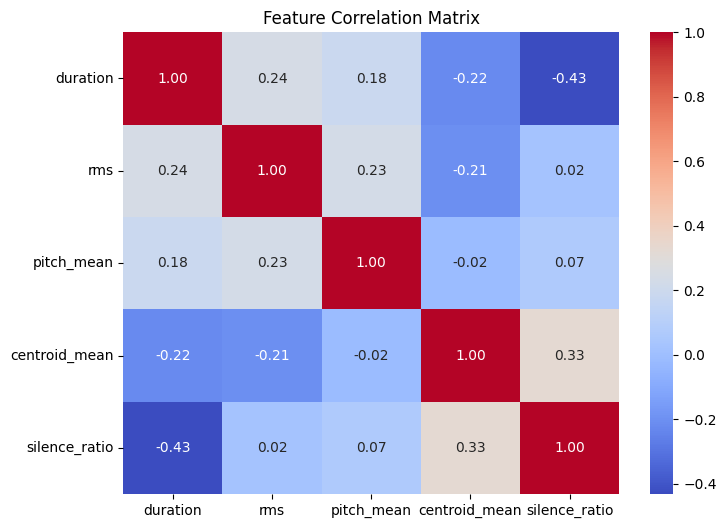

In [16]:
num_cols = ['duration', 'rms', 'pitch_mean', 'centroid_mean', 'silence_ratio']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [17]:
# emotion_groups = df.groupby("emotion")["path"].apply(list)
# for e in ["neutral", "angry", "sad", "happy"]:
#     print(f"{e.upper()}")
#     explore_audio(emotion_groups[e][0])


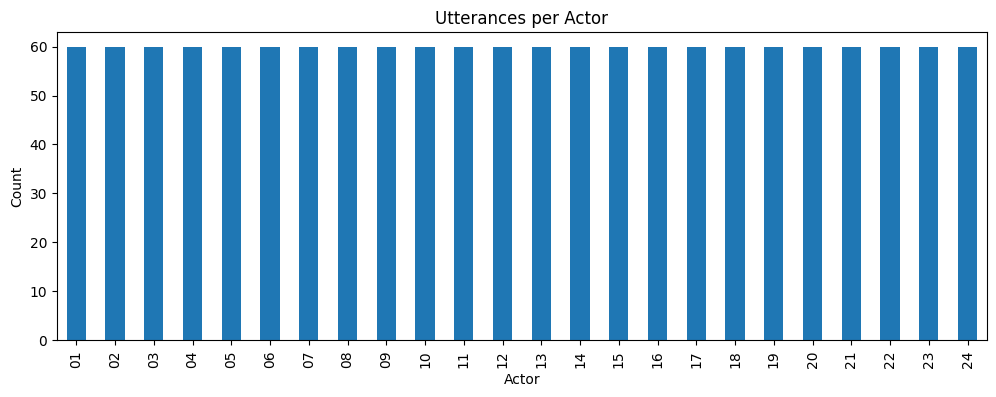

In [18]:
actor_counts = df['actor'].value_counts()
plt.figure(figsize=(12,4))
actor_counts.plot(kind='bar')
plt.title("Utterances per Actor")
plt.xlabel("Actor")
plt.ylabel("Count")
plt.show()


In [19]:
n_mels = 64
embeddings = []

for audio_file in tqdm(df['path'], desc="Building embeddings"):
    signal, sr = librosa.load(audio_file, sr=None)

    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    emb = np.mean(mel_db, axis=1)
    embeddings.append(emb)

embeddings = np.stack(embeddings)
df['embedding'] = list(embeddings)
print("Embedding shape:", embeddings.shape)


Building embeddings: 100%|██████████| 1440/1440 [01:00<00:00, 23.71it/s]

Embedding shape: (1440, 64)


In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)
df['pca_x'] = X_pca[:, 0]
df['pca_y'] = X_pca[:, 1]


In [21]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(embeddings)
df['tsne_x'] = X_tsne[:, 0]
df['tsne_y'] = X_tsne[:, 1]


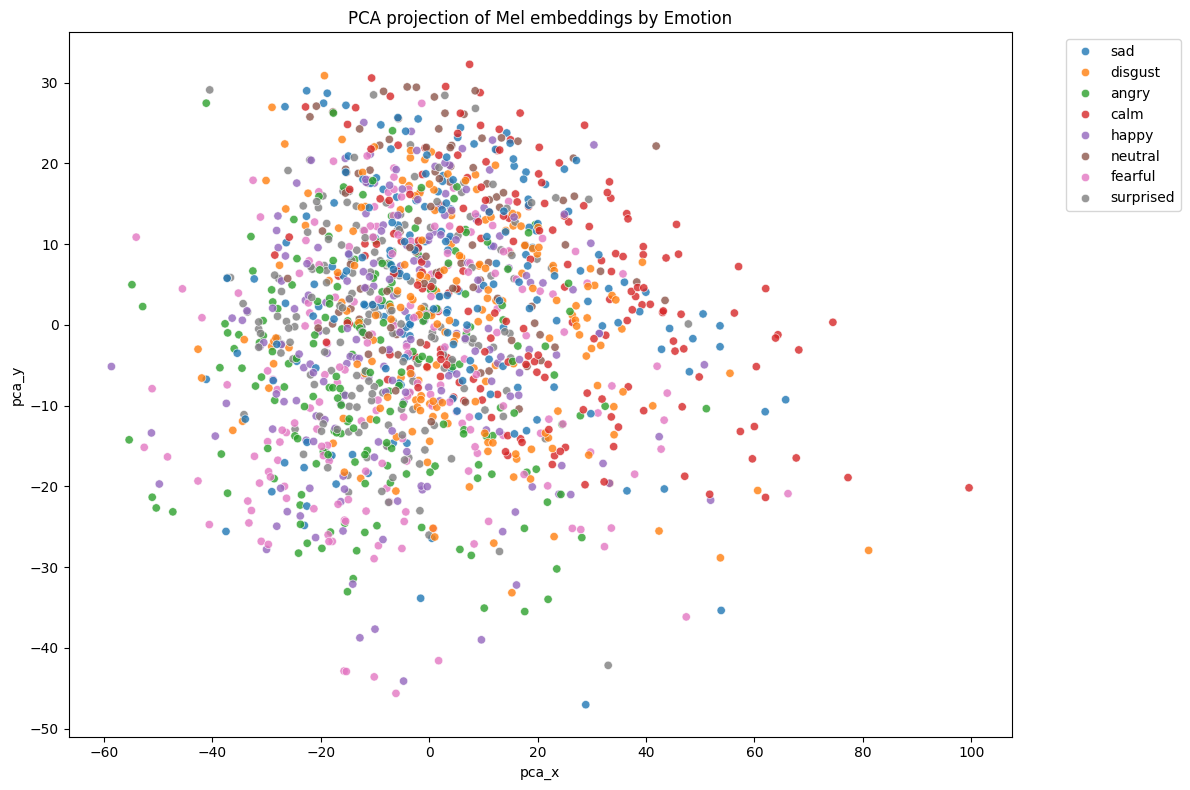

In [22]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='pca_x',
    y='pca_y',
    hue='emotion',
    palette='tab10',
    alpha=0.8
)
plt.title('PCA projection of Mel embeddings by Emotion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


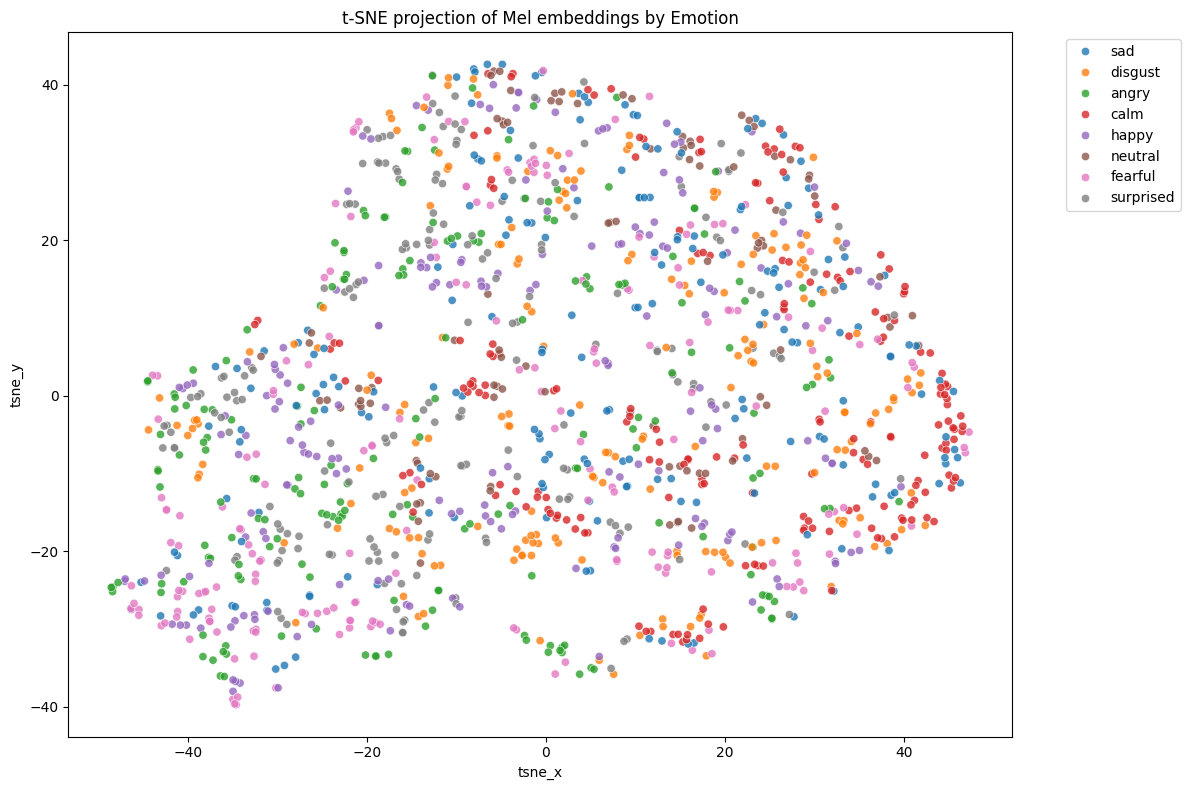

In [23]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='tsne_x',
    y='tsne_y',
    hue='emotion',
    palette='tab10',
    alpha=0.8
)
plt.title('t-SNE projection of Mel embeddings by Emotion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


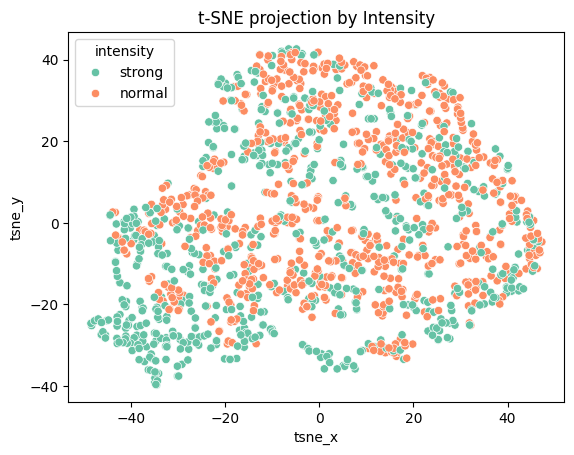

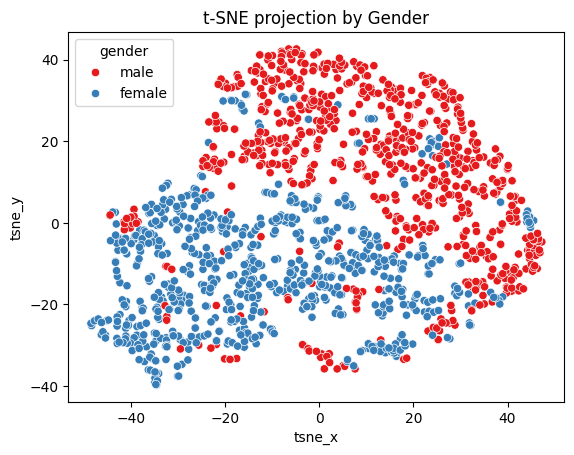

In [24]:
sns.scatterplot(data=df, x='tsne_x', y='tsne_y', hue='intensity', palette='Set2')
plt.title('t-SNE projection by Intensity')
plt.show()

sns.scatterplot(data=df, x='tsne_x', y='tsne_y', hue='gender', palette='Set1')
plt.title('t-SNE projection by Gender')
plt.show()


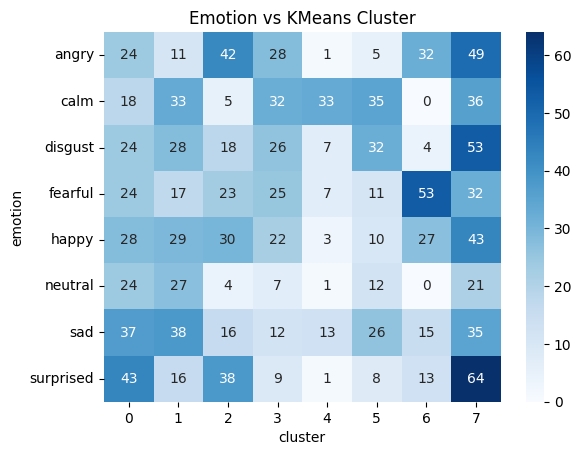

In [25]:
from sklearn.cluster import KMeans

n_clusters = 8  # since RAVDESS has 8 emotions
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

sns.heatmap(pd.crosstab(df['emotion'], df['cluster']), annot=True, cmap='Blues')
plt.title("Emotion vs KMeans Cluster")
plt.show()


In [26]:
"""
RAVDESS EDA Feature Columns
---------------------------
Columns:
- path             : Full file path to the original audio sample.
- actor            : Numeric speaker/actor ID (01–24 in RAVDESS).
- emotion          : Emotion label (e.g., 'happy', 'sad', 'angry', ...).
- intensity        : Emotion intensity level ('normal' or 'strong').
- vocal            : Vocal type ('speech' or 'song').
- gender           : Speaker gender ('male' or 'female', derived from actor ID).
- duration         : Total duration of the audio clip in seconds.
- sr               : Sampling rate of the audio file (Hz).
- rms              : Root Mean Square amplitude — an estimate of average loudness.
- pitch_mean       : Mean fundamental frequency (F0) of the voice in Hz,
                     computed from non-zero pitch frames.
- centroid_mean    : Mean spectral centroid (Hz), representing the "brightness"
                     or frequency center of mass of the sound.
- silence_ratio    : Ratio of silence in the clip (0–1), estimated using energy
                     threshold trimming (higher = more silence).
- pca_x, pca_y     : 2D coordinates of the audio’s mel embedding after PCA
                     dimensionality reduction.
- tsne_x, tsne_y   : 2D coordinates of the audio’s mel embedding after t-SNE
                     dimensionality reduction, useful for visualizing
                     clustering structure.
- cluster          : Unsupervised KMeans cluster label assigned based on
                     mel-spectrogram embeddings (0–n_clusters-1).

"""

eda_cols = [
    'path', 'actor', 'emotion', 'intensity', 'vocal', 'gender',
    'duration','sr', 'rms', 'pitch_mean', 'centroid_mean', 'silence_ratio',
    'pca_x', 'pca_y', 'tsne_x', 'tsne_y', 'cluster'
]

df[eda_cols].to_csv('report/ravdess_eda.csv', index=False)
print("CSV file saved as ravdess_eda.csv")

summary = df[eda_cols].describe(include='all')
summary.to_csv('report/ravdess_eda_summary.csv')

np.save("report/ravdess_embeddings.npy", embeddings)
print("Saved embeddings to ravdess_embeddings.npy")

CSV file saved as ravdess_eda.csv
Saved embeddings to ravdess_embeddings.npy


In [27]:
# emb = np.load("report/ravdess_embeddings.npy")
# print("Shape:", emb.shape)
# print("vector: \n", emb)
